<a href="https://colab.research.google.com/github/vinuri-g/ML_Assignment2_IT19113982_IT19143200_IT19165394_IT19173200/blob/sanda-d/cholesterol_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Cholesterol Risk Level Using Machine Learning**

Cholesterol is a type of fat which moves through our body through blood. Cholesterol is made from our body as well as contained in the food we take in. Cholesterol is important to make layers inside blood vessels which act as a gatekeeper for things to move in and out of body cells. But there is a certain level of cholesterol that is needed for this. That is why it is important for one’s health to maintain the level of cholesterol needed without letting it go below or above the required range. Using attributes such as age, gender, height, weight, smoking habits and calorie level, we can, predict the cholesterol risk of a person. 

In [7]:
# Import libraries, features and settings

import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from operator import truediv
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix

Data Source : https://www.kaggle.com/code/sulianova/eda-cardiovascular-data/data

In [8]:
# Read dataset and Creating a dataframe

df = pd.read_csv("cardio_train.csv", sep=";")

## Data Exploration & Pre-Processing

When using a readily available dataset, there are instances where we have to add, remove or change the dataset in order to format it to suit the machine language model we are building. This is known as data preprocessing.

In [9]:
df.head() #Display the dataset

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


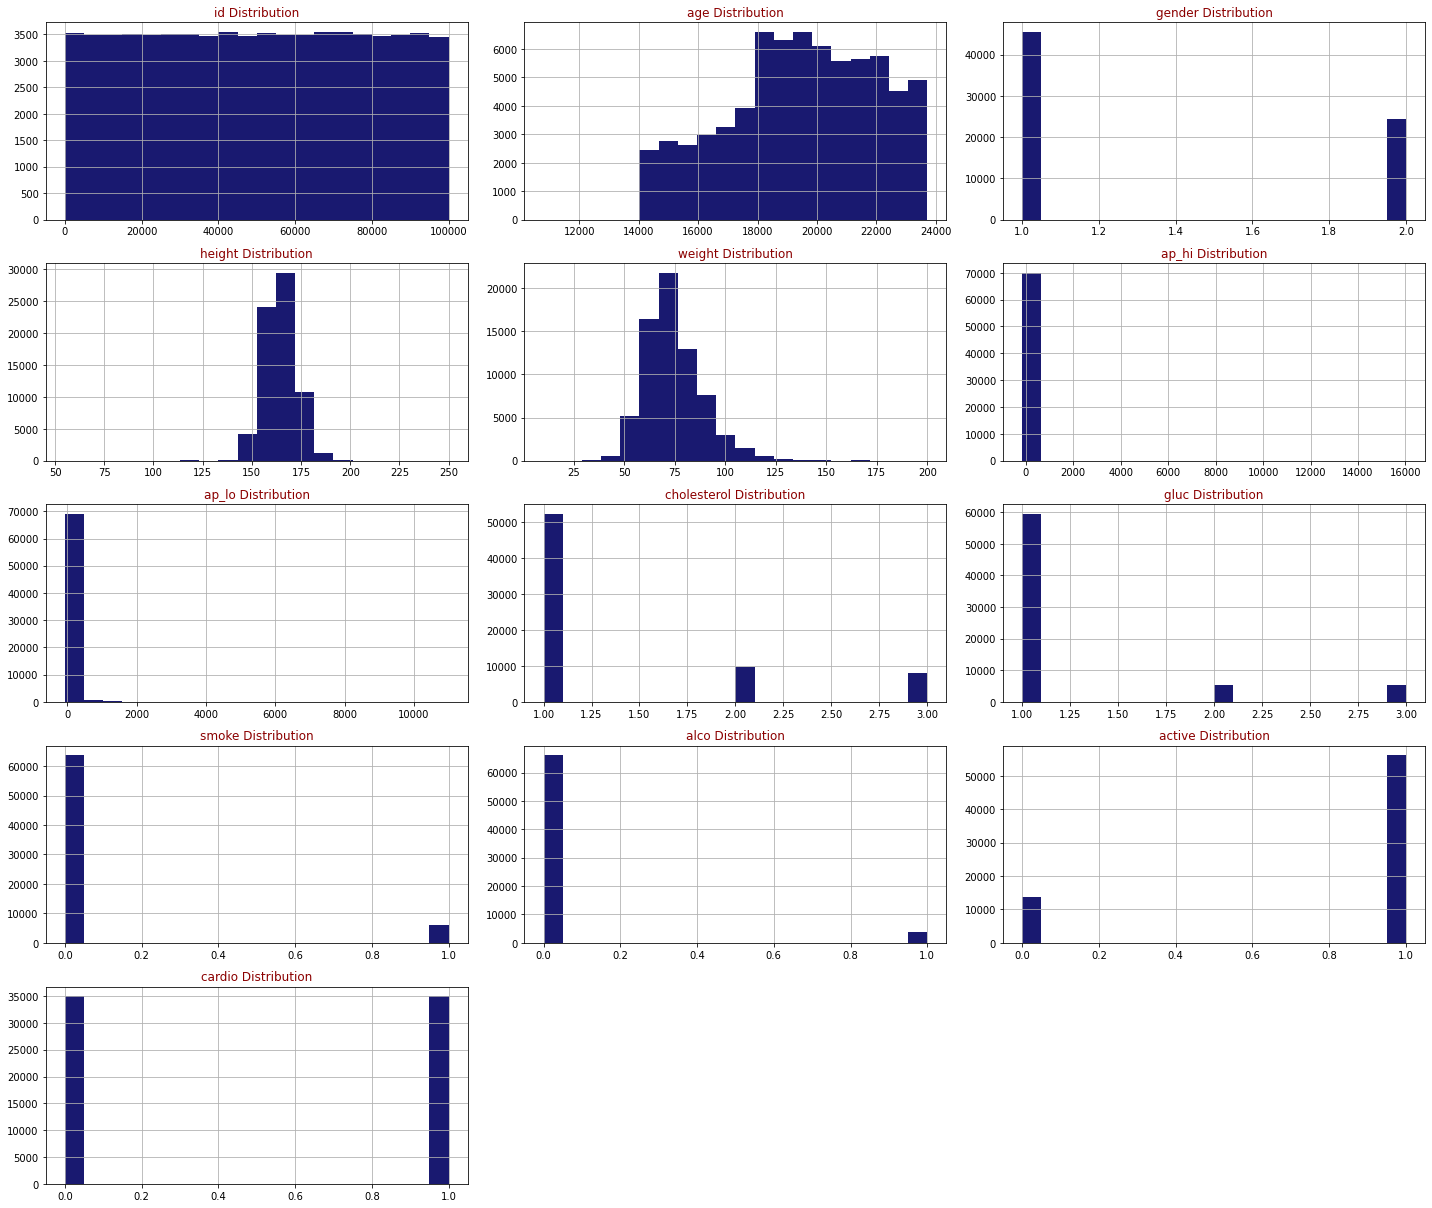

In [10]:
# Draw histograms for all columns

def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_histograms(df,df.columns,6,3)

In [11]:
df['cholesterol'].value_counts() # Check count of data rows by categories

1    52385
2     9549
3     8066
Name: cholesterol, dtype: int64

Undersampling is a technique designed to balance the class distribution for a classification dataset that has a skewed class distribution.

An imbalanced class distribution will have one or more classes with few examples (the minority classes) and one or more classes with many examples (the majority classes).


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


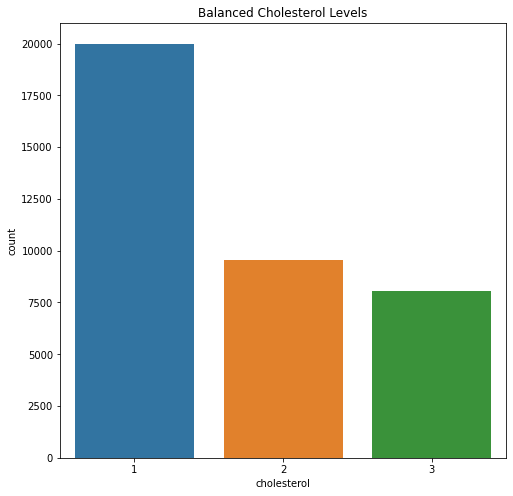

In [12]:
# Normalizing dataset using undersampling method

shuffled_df = df.sample(frac=1, random_state=4) # Shuffle the dataset

mid_col_df = shuffled_df.loc[shuffled_df['cholesterol'] == 2] 
high_col_df = shuffled_df.loc[shuffled_df['cholesterol'] == 3]
non_fraud_df = shuffled_df.loc[shuffled_df['cholesterol'] == 1].sample(n=20000, random_state=42) # Randomly select 10000 datas from majority class

normalized_df = pd.concat([mid_col_df, high_col_df, non_fraud_df]) # Concatenate all dataframes 

# Plot the normalized dataset
plt.figure(figsize=(8,8))
sn.countplot('cholesterol', data=normalized_df)
plt.title('Balanced Cholesterol Levels')
plt.show()

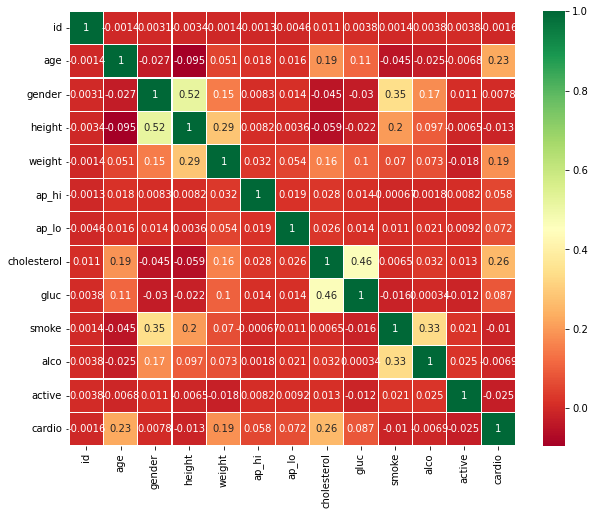

In [13]:
# Draw heatmap for the dataset

sn.heatmap(normalized_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [14]:
# Draw frequency table to understand distribution of Glucose and Cholesterol variables

normalized_df.groupby(['gluc', 'cholesterol']).size()

gluc  cholesterol
1     1              18547
      2               6729
      3               4078
2     1                879
      2               2439
      3                516
3     1                574
      2                381
      3               3472
dtype: int64

In [15]:
# Functions to calculate BMR

def calculate_bmr_male(df):
    return round(66.5 + (13.75 * df['weight']) + (5.003 * df['height']) - (6.75 * (df['age'] / 365)) ,2)

def calculate_bmr_female(df):
    return round(655.1 + (9.563 * df['weight']) + (1.850 * df['height']) - (4.676 * (df['age'] / 365)), 2)

In [16]:
# Calclate BMR and add Average Calorie Intake to the dataset

normalized_df['activity_factor'] = [1.55 if x == 1 else 1.2 for x in normalized_df['active']]
normalized_df['bmr'] = np.where(normalized_df['gender'] == 1, calculate_bmr_female(normalized_df), calculate_bmr_male(normalized_df))
normalized_df['avg_calorie'] = round(normalized_df['bmr'] * normalized_df['activity_factor'], 2)

In [17]:
# Categorize Average Calorie Intake

normalized_df['avg_cal_range'] = pd.cut(normalized_df.avg_calorie, [0,1200,1800,2500,7000], labels=[1,2,3,4], right=False)

normalized_df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,activity_factor,bmr,avg_calorie
count,37615.000000,37615.000000,37615.000000,37615.000000,37615.000000,37615.000000,37615.000000,37615.000000,37615.000000,37615.000000,37615.000000,37615.000000,37615.000000,37615.000000,37615.000000,37615.000000
mean,49925.936913,19630.492623,1.343108,164.166955,75.161806,130.512960,99.257557,1.682733,1.337312,0.091373,0.059896,0.804785,0.552811,1.481675,1482.489209,2196.308009
std,28895.788011,2451.441612,0.474753,8.235629,14.848240,155.117336,187.114868,0.803428,0.677444,0.288143,0.237298,0.396371,0.497210,0.138730,205.838246,367.651044
min,0.000000,10798.000000,1.000000,64.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.200000,681.750000,1056.710000
25%,24884.500000,18091.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.550000,1337.530000,1970.405000
50%,50103.000000,19808.000000,1.000000,164.000000,73.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.550000,1443.500000,2166.670000
75%,74912.500000,21701.000000,2.000000,170.000000,84.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.550000,1590.720000,2401.955000
max,99999.000000,23692.000000,2.000000,250.000000,200.000000,14020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.550000,3437.480000,5328.090000


In [18]:
normalized_df['age'] = round(normalized_df['age'] / 365) # Convert age into years

# Dropping unnecessary columns
normalized_df.drop(['id', 'ap_hi', 'ap_lo', 'alco', 'active', 'cardio', 'activity_factor', 'bmr', 'avg_calorie'], axis=1, inplace=True)

normalized_df.head()

,age,gender,height,weight,cholesterol,gluc,smoke,avg_cal_range
60025,59.0,1,158,82.0,2,1,0,3
30112,44.0,2,174,108.0,2,1,1,4
45191,41.0,1,165,75.0,2,2,0,3
19090,54.0,2,171,80.0,2,2,0,4
54153,57.0,1,168,85.0,2,1,0,3


In [19]:
normalized_df.apply(lambda x: sum(x.isnull())) # Checking for null values

age              0
gender           0
height           0
weight           0
cholesterol      0
gluc             0
smoke            0
avg_cal_range    0
dtype: int64

Label Encoding refers to converting the labels into a numeric form so as to convert them into the machine-readable form. Machine learning algorithms can then decide in a better way how those labels must be operated.

In [20]:
# Encode categorical variable with values

labeler = LabelEncoder()
normalized_df["cholesterol"] = labeler.fit_transform(normalized_df["cholesterol"])
normalized_df["avg_cal_range"] = labeler.fit_transform(normalized_df["avg_cal_range"])

print (normalized_df.dtypes)

age              float64
gender             int64
height             int64
weight           float64
cholesterol        int64
gluc               int64
smoke              int64
avg_cal_range      int64
dtype: object


In [21]:
# Splitting the dataset

X = normalized_df[['age', 'gender', 'height', 'weight', 'smoke', 'gluc', 'avg_cal_range']]
y = normalized_df['cholesterol']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)